### Import libraries

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline
from sklearn.metrics import roc_auc_score, classification_report, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier ,RandomForestClassifier ,GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

### Load processed dataset

In [14]:
path = '../data/'
train = pd.read_csv(path+'processed-train.csv',delimiter=',')
test = pd.read_csv(path+'processed-test.csv',delimiter=',')
train.head()

,age,month,day_of_week,campaign,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,...,default_yes,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,poutcome_failure,poutcome_nonexistent,poutcome_success
0,0.020008,7,1,-0.197592,0.845278,0.599115,-0.492143,0.772161,0.865359,-1,...,0,0,1,1,0,0,1,0,1,0
1,-0.931606,5,1,0.976451,-1.229913,-1.281918,-1.329137,-1.380273,-1.009784,-1,...,0,1,0,1,0,1,0,0,1,0
2,1.923236,5,1,2.150493,-1.229913,-1.281918,-1.329137,-1.316557,-1.009784,-1,...,0,1,0,1,0,1,0,1,0,0
3,0.337212,7,2,1.563472,0.845278,0.599115,-0.492143,0.772740,0.865359,-1,...,0,0,1,1,0,1,0,0,1,0
4,-0.085727,5,4,-0.197592,0.650729,0.738587,1.014446,0.714238,0.326073,-1,...,0,1,0,1,0,0,1,0,1,0


### Split data into features and labels

In [15]:
# Predictors
x_train = train.drop(['y'], 1)
x_test = test.drop(['y'], 1)

# Target values
y_train = train['y']
y_test = test['y']

### Baseline algorithms

Let us run some baseline algorithms with default hyper-parameters on the training data to see how they perform. We will consider the following algorithms: **Logistic regression**, **Decision tree**, **Random forest**, **Support vector machine** and **k-Nearest neighbor**. For each algorithm, we will perform 5-fold cross-validation on the training set and store the mean classification accuracy and mean AUC-ROC (Area under ROC curve) along with the standard deviations.

In [40]:
# Make a list of algorithms to implement
models = []
models.append(('Logistic regression', LogisticRegression(max_iter=500)))
models.append(('Decision tree', DecisionTreeClassifier()))
models.append(('Random forest', RandomForestClassifier()))
models.append(('Support vector machine', SVC()))
models.append(('k-Nearest neighbor', KNeighborsClassifier()))

In [41]:
# Make a dataframe to store classification metrics
col = ['Algorithm', 'Mean ROC-AUC', 'S.D. AUC-ROC', 'Mean Accuracy', 'S.D. Accuracy']
df_results = pd.DataFrame(columns=col)
auc_results = []
acc_results = []
i = 0

# Fit the models one by one
for name, model in models:
    kfold = KFold(n_splits=5, shuffle=True, random_state=10)  # 5-fold cross-validation
    cv_auc_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring='roc_auc')
    auc_results.append(cv_auc_results)
    cv_acc_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring='accuracy')
    acc_results.append(cv_acc_results)
    df_results.loc[i] = [name,
                         round(cv_auc_results.mean()*100),
                         round(cv_auc_results.std()*100),
                         round(cv_acc_results.mean()*100),
                         round(cv_acc_results.std()*100)
                         ]
    i += 1
    print(i)
df_results.sort_values(by=['Mean ROC-AUC'], ascending=False)

1
2
3
4
5


,Algorithm,Mean ROC-AUC,S.D. AUC-ROC,Mean Accuracy,S.D. Accuracy
0,Logistic regression,78.0,0.0,90.0,0.0
2,Random forest,77.0,0.0,89.0,0.0
4,k-Nearest neighbor,73.0,0.0,89.0,0.0
3,Support vector machine,71.0,1.0,90.0,0.0
1,Decision tree,63.0,1.0,84.0,0.0


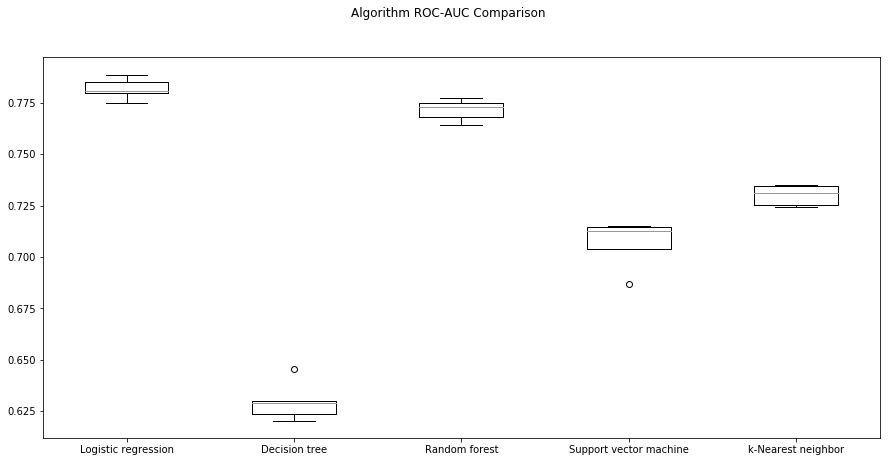

In [46]:
fig = plt.figure(figsize=(15, 7))
fig.suptitle('Algorithm ROC-AUC Comparison')
ax = fig.add_subplot(111)
plt.boxplot(auc_results)
ax.set_xticklabels(df_results['Algorithm'])
plt.show()

In [45]:
cv_auc_results

array([0.72443188, 0.73501131, 0.72515961, 0.73453655, 0.73091223])